## Review

OK, let's review what we've learned so far with our experiments

* Read rate is inversely proportional to slice fragmentation
* Reading from RAM is really, really fast (after paying the initial cost)
* RAM is limited, so some comprimise is necessary

So far we have only been praciticing I/O with a simple multidimensional array. Let's explore the usage of the NetCDF library and investigate what it provides for us.

In [1]:
import os
from tempfile import mkstemp

import netCDF4
from matplotlib import pyplot
%matplotlib inline

Let's start by creating an empty NetCDF file to contain the same array that we had computed before. Then we'll iteratively compute the array and write it out to the NetCDF.

In [2]:
_, filename = mkstemp(suffix='.nc', dir=os.getcwd())

shape = (256, 1024, 1024)

nc = netCDF4.Dataset(filename, 'w', format='NETCDF3_CLASSIC')
nc.createDimension('z', shape[2])
nc.createDimension('y', shape[1])
nc.createDimension('x', shape[0])
some_var = nc.createVariable('some_variable','f4',('x', 'y', 'z'))

In [3]:
print(some_var.dimensions, some_var.shape)

('x', 'y', 'z') (256, 1024, 1024)


In [23]:
import numpy as np
import math

def f(x, y, z):
    d = math.sqrt((x - 256) ** 2 + (y - 256) ** 2)
    return math.sin(d / 64) + math.sin(z)
f_v = np.vectorize(f)

x, y = np.meshgrid(range(shape[2]), range(shape[1]))
basegrid = f_v(x, y, 0).astype('float32')

for z in range(shape[0]):
    a = basegrid + math.sin(z / 32)
    some_var[z,:,:] = a


In [24]:
!ls -l $filename

-rw------- 1 james james 1073741948 Apr 22 14:44 /home/james/code/git/netcdf-tutorial/notebooks/tmpfgbjcy.nc


In [25]:
1073741948 - 2 ** 30

124

So a classic NetCDF3 is essentially just the array that we built in part 1 with a few bytes of header appended to the beginning. I wonder whether our same access methods would work? Let's try. We'll try and extract the first 1024 * 1024 cells, which should equivalent to our basegrid. So it should look like this:

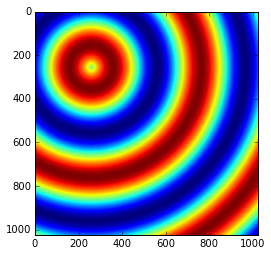

In [26]:
pyplot.imshow(basegrid)

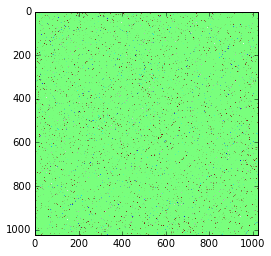

In [27]:
with open(filename, 'rb') as nc_file:
    nc_file.seek(124)
    bytes_ = nc_file.read(1024 * 1024 * 4)

a = np.fromstring(bytes_, np.dtype('float32')).reshape((1024, 1024))
pyplot.imshow(a)


*That's* not right. What's going on here? It turns out that NetCDF byte order, or *endianness* is reversed from the standard C byte order. For example, if the four bytes of a number were in C were 16bf a50f 18bf 5a57, then in NetCDF they are stored as: 5a57 18bf a50f 16bf.

`numpy` is written by people who handle this sort of confusion all of the time, so there's any easy way to deal with this. Just call the array's `byteswap` method, and it will reverse the bytes for you (sort of, technical it changes an attribute that specifies whether to read them in forward or reverse order).

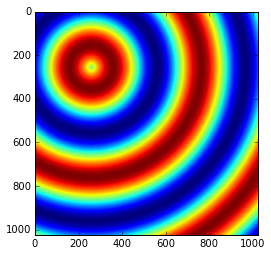

In [28]:
a = a.byteswap(True)
pyplot.imshow(a)


And there we are! We have our original array, using regular old binary read. Notice that if we ask whether the arrays are equal, we find out that they are.

In [41]:
np.all(a == basegrid)

True

I should note as an aside, that when I was preparing this tutorial, initially I found that the what I read out of NetCDF file was off from my base array somewhere in the $ 1.0 \times 10 ^ {-08} $ range. I accidentally hadn't specified the number of bytes in my original array, so it was using the native float8 (64-bit) and then converting that down to 32-bit when it stuff it in the NetCDF file. It made it *appear* as though I was losing preicision through the round trip to/from the file, but really I had lost it before-hand.

## File I/O with the NetCDF library

In any case, we've demonstrated that a classic NetCDF3 file is nothing more than an ordinary byte array with a header at the beginning. Does it do any better at file I/O than we could with our regular Python implementation?


In [45]:
%%timeit
a = some_var[:,:,:]

1 loops, best of 3: 5.79 s per loop


So it's actually a little bit slower than our Python implementation, but *boy* is the code simpler!